In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Import estimators
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

# Import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

# Import preprocessing pipeline
from src.features import preprocessing_pipeline

pd.set_option('display.max_columns', None)

%load_ext autoreload
%autoreload 2

path_processed = '/home/matteo@COPPET/Documents/data_science/projects/housing_prices_firenze/data/processed/'

In [2]:
df = pd.read_csv(path_processed+'data_clean.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8714 entries, 0 to 8713
Data columns (total 57 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Tipologia                                  8714 non-null   object 
 1   Tipo_proprietà                             8277 non-null   object 
 2   Zona                                       8714 non-null   object 
 3   Anno_costruzione                           6334 non-null   float64
 4   Stato                                      8483 non-null   object 
 5   Prezzo_EUR                                 8714 non-null   float64
 6   Superficie_m2                              8714 non-null   float64
 7   Prezzo_per_m2                              8714 non-null   float64
 8   Riscaldamento_A_C                          8714 non-null   object 
 9   Tipo_riscaldamento                         6760 non-null   object 
 10  Alimentazione_riscaldame

### 1. Feature selection and splitting data

In [3]:
target = 'Prezzo_EUR'

X = df.drop(columns=['Prezzo_per_m2']+[target])
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### 2. Modeling

#### 2.1 First model (benchmarking)

In [13]:
lr = LinearRegression()

pipe = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('model', lr)
])

pipe.fit(X_train, y_train)
y_train_pred = pipe.predict(X_train)

# Train set score
print('Training set score: {}'.format(mean_absolute_error(y_train, y_train_pred)))

# Cross validation score
scores = cross_val_score(pipe, X_train, y_train, scoring='neg_mean_absolute_error', cv=10)
print('Mean cross validation score: {}'.format(np.mean(-scores)))

Training set score: 142758.57216963812
Mean cross validation score: 148856.3810340354


#### 2.2 Other models

In [14]:
rr = Ridge()

pipe = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('model', rr)
])

pipe.fit(X_train, y_train)
y_train_pred = pipe.predict(X_train)

# Train set score
print('Training set score: {}'.format(mean_absolute_error(y_train, y_train_pred)))

# Cross validation score
scores = cross_val_score(pipe, X_train, y_train, scoring='neg_mean_absolute_error', cv=10)
print('Mean cross validation score: {}'.format(np.mean(-scores)))

Training set score: 142702.85749248794
Mean cross validation score: 148751.77269511853


In [7]:
# Regularization parameter
alphas = []
train_scores = []
test_scores = []
for i in range(100):
    alpha = i
    alphas.append(alpha)
    
    rr = Ridge(alpha=alpha)
    pipe = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('model', rr)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_train)
    train_scores.append(mean_absolute_error(y_train, y_pred))
    scores = cross_val_score(pipe, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
    test_scores.append(np.mean(-scores))

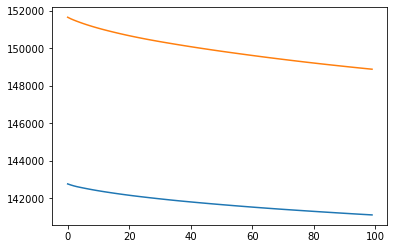

In [8]:
plt.plot(alphas, train_scores)
plt.plot(alphas, test_scores)
plt.show()

In [16]:
rf = RandomForestRegressor(random_state=0)

pipe = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('model', rf)
])

pipe.fit(X_train, y_train)
y_train_pred = pipe.predict(X_train)

# Train set score
print('Training set score: {}'.format(mean_absolute_error(y_train, y_train_pred)))

# Cross validation score
scores = cross_val_score(pipe, X_train, y_train, scoring='neg_mean_absolute_error', cv=10)
print('Mean cross validation score: {}'.format(np.mean(-scores)))

Training set score: 38032.5498374217
Mean cross validation score: 101494.51376120746


### 3. Hyperparameter tuning

In [32]:
rf = RandomForestRegressor(random_state=0)

pipe = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('model', rf)
])

from sklearn.model_selection import GridSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 4)]
# Number of features to consider at every split
max_features = [2, 3, 4]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 5)]
max_depth.append(None)
# Split criterion
criterion = ['mse', 'mae']
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
#param_grid = {'n_estimators': n_estimators,
#               'max_features': max_features,
#               'max_depth': max_depth,
#               'criterion': criterion,
#               'min_samples_split': min_samples_split,
#               'min_samples_leaf': min_samples_leaf,
#               'bootstrap': bootstrap}

param_grid = [
{'model__n_estimators': [20, 30, 40], 'model__max_features': [6, 8, 10], 'model__min_samples_split': [2, 5, 10],
 'model__min_samples_leaf': [1, 2, 4]},
#{'model__bootstrap': [False], 'model__n_estimators': [3, 10], 'model__max_features': [2, 3, 4]},
]

grid_search = GridSearchCV(pipe, param_grid, cv=5, verbose=0, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(-mean_score, params)

113754.411049257 {'model__max_features': 6, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 20}
111608.07312144418 {'model__max_features': 6, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 30}
111437.03706403139 {'model__max_features': 6, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 40}
115539.04081124754 {'model__max_features': 6, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 20}
112641.48061626844 {'model__max_features': 6, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 30}
111547.63596452307 {'model__max_features': 6, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 40}
116508.62916741215 {'model__max_features': 6, 'model__min_samples_leaf': 1, 'model__min_samples_split': 10, 'model__n_estimators': 20}
114642.36728287167 {'model__max_features': 6, 'model__min_sampl

In [33]:
pipe = grid_search.best_estimator_

pipe.fit(X_train, y_train)
y_train_pred = pipe.predict(X_train)

# Train set score
print('Training set score: {}'.format(mean_absolute_error(y_train, y_train_pred)))

# Cross validation score
scores = cross_val_score(pipe, X_train, y_train, scoring='neg_mean_absolute_error', cv=10)
print('Mean cross validation score: {}'.format(np.mean(-scores)))

Training set score: 41927.12008957745
Mean cross validation score: 105196.66061831175


Clearly the random forest is wildly overfitting the data.

### 4. Principal Component Analysis

In [37]:
from sklearn.decomposition import PCA

pca = PCA()
rf = RandomForestRegressor(random_state=0)

pipe = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('pca', pca),
    ('model', rf)
])

param_grid = {'pca__n_components': [5, 10, 20, 30, 40, 50, None]}

grid_search = GridSearchCV(pipe, param_grid, cv=5, verbose=0, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(-mean_score, params)

153764.96094521153 {'pca__n_components': 5}
131949.95895048854 {'pca__n_components': 10}
133164.05451082456 {'pca__n_components': 20}
132766.4654129521 {'pca__n_components': 30}
133837.65760871855 {'pca__n_components': 40}
132832.85395328994 {'pca__n_components': 50}
133690.57360255922 {'pca__n_components': None}


In [38]:
pipe = grid_search.best_estimator_

pipe.fit(X_train, y_train)
y_train_pred = pipe.predict(X_train)

# Train set score
print('Training set score: {}'.format(mean_absolute_error(y_train, y_train_pred)))

# Cross validation score
scores = cross_val_score(pipe, X_train, y_train, scoring='neg_mean_absolute_error', cv=10)
print('Mean cross validation score: {}'.format(np.mean(-scores)))

Training set score: 48839.77624307506
Mean cross validation score: 131788.35761198617
